In [1]:
from QES.Algebra.Model.Interacting.Spin.heisenberg_kitaev   import HeisenbergKitaev, HoneycombLattice, Z_BOND_NEI, X_BOND_NEI, Y_BOND_NEI
from QES.Algebra.hilbert                                    import HilbertSpace
from QES.Algebra.Operator.impl.operators_spin               import sig_x, sig_y, sig_z, spin_plaquette, spin_plaquettes
from QES.Algebra.Operator.impl.operators_spin               import spin_plaquette
from QES.general_python.common.flog                         import get_logger

import matplotlib.pyplot                                    as plt
import numpy                                                as np
logger = get_logger(use_ts_in_cmd=False)

In [17]:
lat             = HoneycombLattice(lx=3, ly=3, bc='pbc')
lat

HON,pbc,d=2,Ns=18,Lx=3,Ly=3,Lz=1

(<Figure size 525x393.75 with 1 Axes>, <Axes: >)

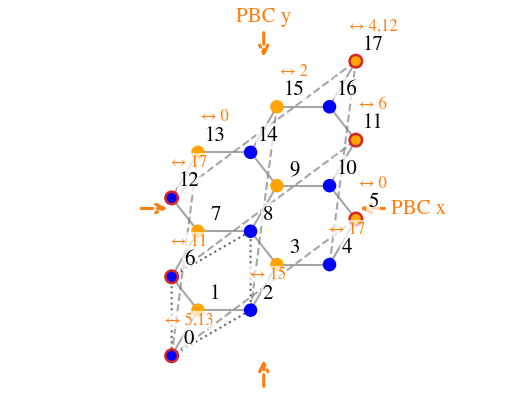

In [18]:
lat.plot_structure(show_indices=True, partition_colors=['blue', 'orange'], highlight_boundary=True, boundary_offset=0.1)

In [19]:
plaquettes  = lat.calculate_plaquettes()
bond_to_op  = {
                X_BOND_NEI : 'X',
                Y_BOND_NEI : 'Y',
                Z_BOND_NEI : 'Z',
            }

print(f"Plaquettes: {plaquettes}")
paulis      = []

for i, p in enumerate(plaquettes):
    print(f"Plaquette {i}: Sites {p}")
    pauli, codes    = spin_plaquette(p, lattice=lat, return_op=True, bond_to_op=bond_to_op)
    print(f"    {pauli}")
    print(f"    Codes: {codes}")
    paulis.append(pauli)

Plaquettes: [[1, 6, 7, 8, 3, 2], [3, 8, 9, 10, 5, 4], [7, 12, 13, 14, 9, 8], [9, 14, 15, 16, 11, 10]]
Plaquette 0: Sites [1, 6, 7, 8, 3, 2]
    Pauli:S_Y,S_Z,S_X,S_Y,S_Z,S_X/1-6-7-8-3-2(act=Global)
    Codes: [1, 2, 0, 1, 2, 0]
Plaquette 1: Sites [3, 8, 9, 10, 5, 4]
    Pauli:S_Y,S_Z,S_X,S_Y,S_Z,S_X/3-8-9-10-5-4(act=Global)
    Codes: [1, 2, 0, 1, 2, 0]
Plaquette 2: Sites [7, 12, 13, 14, 9, 8]
    Pauli:S_Y,S_Z,S_X,S_Y,S_Z,S_X/7-12-13-14-9-8(act=Global)
    Codes: [1, 2, 0, 1, 2, 0]
Plaquette 3: Sites [9, 14, 15, 16, 11, 10]
    Pauli:S_Y,S_Z,S_X,S_Y,S_Z,S_X/9-14-15-16-11-10(act=Global)
    Codes: [1, 2, 0, 1, 2, 0]


In [20]:
for i, nns in enumerate(lat.nn):  # [X, Y, Z] neighbors
    print(f"Site {i}:")
    logger.info(f"  X neighbor: {nns[0]}", color="cyan")
    logger.info(f"  Y neighbor: {nns[1]}", color="orange")
    logger.info(f"  Z neighbor: {nns[2]}", color="green")
    

Site 0:
08_01_2026_19-38_44 [INFO]   X neighbor: 13
08_01_2026_19-38_44 [INFO]   Y neighbor: 1
08_01_2026_19-38_44 [INFO]   Z neighbor: 5
Site 1:
08_01_2026_19-38_44 [INFO]   X neighbor: 6
08_01_2026_19-38_44 [INFO]   Y neighbor: 0
08_01_2026_19-38_44 [INFO]   Z neighbor: 2
Site 2:
08_01_2026_19-38_44 [INFO]   X neighbor: 15
08_01_2026_19-38_44 [INFO]   Y neighbor: 3
08_01_2026_19-38_44 [INFO]   Z neighbor: 1
Site 3:
08_01_2026_19-38_44 [INFO]   X neighbor: 8
08_01_2026_19-38_44 [INFO]   Y neighbor: 2
08_01_2026_19-38_44 [INFO]   Z neighbor: 4
Site 4:
08_01_2026_19-38_44 [INFO]   X neighbor: 17
08_01_2026_19-38_44 [INFO]   Y neighbor: 5
08_01_2026_19-38_44 [INFO]   Z neighbor: 3
Site 5:
08_01_2026_19-38_44 [INFO]   X neighbor: 10
08_01_2026_19-38_44 [INFO]   Y neighbor: 4
08_01_2026_19-38_44 [INFO]   Z neighbor: 0
Site 6:
08_01_2026_19-38_44 [INFO]   X neighbor: 1
08_01_2026_19-38_44 [INFO]   Y neighbor: 7
08_01_2026_19-38_44 [INFO]   Z neighbor: 11
Site 7:
08_01_2026_19-38_44 [INFO]  

### Operators defining the honeycomb lattice structure for quantum simulations.

In [21]:
sigma_x_0       = sig_x(lattice=lat, sites=0)
sigma_z_1       = sig_z(lattice=lat, sites=1)
sigma_z_0       = sig_z(lattice=lat, sites=0)
sigma_z_loc     = sig_z(lattice=lat, type_act='local')
sigma_z_corr    = sig_z(lattice=lat, type_act='corr')

In [22]:
plaquettes          = lat.calculate_plaquettes()
plaquette0_op,_     = spin_plaquette(plaquettes[0], lattice=lat, return_op=True)
plaquette1_op,_     = spin_plaquette(plaquettes[1], lattice=lat, return_op=True)
plaquettes_op       = spin_plaquettes([plaquettes[0], plaquettes[1]], lattice=lat, return_op=True)

### a) NO SYMMETRIES

In [23]:
hilbert_no_sym  =   HilbertSpace(lattice=lat)
model_no_sym    =   HeisenbergKitaev(
                        lattice         =   lat, 
                        hilbert_space   =   hilbert_no_sym, 
                        dtype           =   complex,
                        K               =   (-1.0, -1.0, -1.0),
                        hz              =   0.0
                )
model_no_sym

Kitaev(Ns=18,Kx=-1.000,Ky=-1.000,Kz=-1.000,dlt=1.000,hz=0.000)

08_01_2026_19-38_52 [INFO] 		->[Kitaev-Heisenberg-Gamma Model] Calculating the Hamiltonian matrix using NumPy...


array([-14.29150262, -14.29150262, -14.29150262, -14.07463838,
       -14.07463838, -14.07463838])

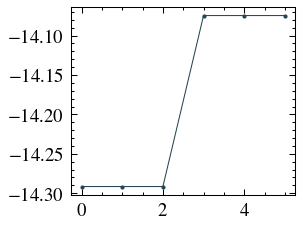

In [24]:
if model_no_sym.eig_val is None: 
    model_no_sym.diagonalize(build=True, method='lanczos', k=6)
    # model_no_sym.diagonalize(build=True, method='exact')

plt.figure(figsize=(2,1.5))
plt.plot(model_no_sym.eig_val, marker='o', ms=1, lw=0.5)
model_no_sym.eig_val[:50]

#### x) Paulis application

In [25]:
bond_to_op  = {
                X_BOND_NEI : 'Z',
                Y_BOND_NEI : 'Y',
                Z_BOND_NEI : 'X',
            }
bond_to_op_r= {v: k for k, v in bond_to_op.items()}

# gram schmidt the eigenvectors
eigvec                  = model_no_sym.eig_vec
# u, s, vh                = np.linalg.svd(eigvec, full_matrices=False)
eigvec_orth             = eigvec
hamil_matrix            = model_no_sym.hamil if model_no_sym.hamil is not None else None
for i, p in enumerate(plaquettes):
    print(f"Plaquette {i}: Sites {p}")
    pauli, codes    = spin_plaquette(p, lattice=lat, return_op=True, bond_to_op=bond_to_op)
    print(f"    {pauli}")
    print(f"    Codes: {codes}")
    for i in range(4):
        matvec          = pauli.matvec(eigvec_orth[:,i], hilbert_in=model_no_sym.hilbert_space)
        exp_val         = np.vdot(eigvec_orth[:,i], matvec)
        print(f"    Expectation value on ground state({i}): {exp_val:.4g}")
    
    if hamil_matrix is not None:
        pauli_matrix    = pauli.matrix(dim=model_no_sym.hilbert_space.nh)
        commutator      = hamil_matrix @ pauli_matrix - pauli_matrix @ hamil_matrix
        commutator      = commutator.toarray() if not isinstance(commutator, np.ndarray) else commutator
        print(commutator[commutator!=0])
        comm_norm       = np.abs(np.linalg.norm(commutator))
        print(f"    Commutator norm with Hamiltonian: {comm_norm:.4g}")
            
# apply step by step
gs_idx          = 0
return_local    = False
state           = eigvec_orth[:,gs_idx]
sig_z_local     = sig_z(lattice=lat, type_act='local', spin_value=1.0)
sig_y_local     = sig_y(lattice=lat, type_act='local', spin_value=1.0)
sig_x_local     = sig_x(lattice=lat, type_act='local', spin_value=1.0)
def decide_pauli(code, return_local=True):
    if code == bond_to_op_r['X']:
        if return_local:
            return sig_x_local
        return sig_x
    elif code == bond_to_op_r['Y']:
        if return_local:
            return sig_y_local
        return sig_y
    elif code == bond_to_op_r['Z']:
        if return_local:
            return sig_z_local
        return sig_z
    else:
        raise ValueError("Unknown neighbor type.")
print("-" * 50)
for i, p in enumerate(plaquettes):
    print(f"Plaquette {i}: Sites {p}")
    state_tmp       = state.copy()
    pauli, codes    = spin_plaquette(p, lattice=lat, return_op=True, bond_to_op=bond_to_op)
    print(f"    Codes: {codes}")

    for site, code in zip(p, codes):
        print(f"    Applying {code} on site {site}")
        pauli_op        = decide_pauli(code, return_local=return_local)
        if return_local:
            state_tmp       = pauli_op.matvec(state_tmp, site, hilbert_in=model_no_sym.hilbert_space)
        else:
            pauli_op        = pauli_op(lattice=lat, sites=site, spin_value=1.0)
            pauli_mat       = pauli_op.matrix(dim=model_no_sym.hilbert_space.nh)
            state_tmp       = pauli_mat @ state_tmp
            
    exp_val         = np.vdot(state, state_tmp)
    print(f"    Expectation value on ground state({gs_idx}): {exp_val:.4g}")

Plaquette 0: Sites [1, 6, 7, 8, 3, 2]
    Pauli:S_Y,S_X,S_Z,S_Y,S_X,S_Z/1-6-7-8-3-2(act=Global)
    Codes: [1, 2, 0, 1, 2, 0]
    Expectation value on ground state(0): 1-2.776e-17j
    Expectation value on ground state(1): 1+1.11e-16j
    Expectation value on ground state(2): 1+1.665e-16j
    Expectation value on ground state(3): 0.5716-8.327e-17j


: 

#### i) Check matrix-vector product for operators that commute with the Hamiltionian $[H, O] = 0$

In [15]:
s_new = model_no_sym.matvec(model_no_sym.eig_vec[:, 0])
s_ovr = np.vdot(model_no_sym.eig_vec[:, 0], s_new)
s_ovr

np.complex128(-6.928203230275505+0j)

#### ii) Check matrix-vector product for operators that do not commute with the Hamiltionian $[H, O] \neq 0$

##### a) Matrix-vector using the generated matrix 

###### i) Applied to the ground state

In [16]:
sigma_z_mat_0       = sigma_z_0.matrix(hilbert_1=hilbert_no_sym)
sigma_z_mat_1       = sigma_z_1.matrix(hilbert_1=hilbert_no_sym)
sigma_x_mat_0       = sigma_x_0.matrix(hilbert_1=hilbert_no_sym)

In [17]:
step1_vec_mat       = sigma_x_mat_0 @ model_no_sym.eig_vec[:, 0]
step2_vec_mat       = sigma_x_mat_0 @ step1_vec_mat
s_ovr_sym_mat       = np.dot(model_no_sym.eig_vec[:, 0], step2_vec_mat)
s_ovr_sym_mat

np.complex128(0.2499999999999999+0j)

In [18]:
step1_vec_mat_z     = sigma_z_mat_1 @ model_no_sym.eig_vec[:, 0]
step2_vec_mat_z     = sigma_z_mat_0 @ step1_vec_mat_z
s_ovr_sym_mat_z     = np.dot(model_no_sym.eig_vec[:, 0], step2_vec_mat_z)
s_ovr_sym_mat_z

np.complex128(-1.6028844918025698e-15+0j)

##### b) Matrix-vector using the `matvec` method

In [19]:
# We apply step by step the symmetry projection
step1_vec   = sigma_x_0.matvec(model_no_sym.eig_vec[:, 0])
step2_vec   = sigma_x_0.matvec(step1_vec)
s_ovr_sym   = np.vdot(model_no_sym.eig_vec[:, 0], step2_vec)
s_ovr_sym

np.complex128(0.2499999999999999+0j)

In [20]:
step1_vec   = sigma_z_1.matvec(model_no_sym.eig_vec[:, 0])
step2_vec   = sigma_z_0.matvec(step1_vec)
s_new2      = step2_vec
s_ovr2      = np.vdot(model_no_sym.eig_vec[:, 0], s_new2)
s_ovr2

np.complex128(-1.6028844918025698e-15+0j)

In [40]:
import numpy as np
import time
import numba

def batch_matvec_benchmark(op, hilbert, eigenvectors, n_iters=50, batch=256):
    """
    Minimal reproduction of correlation-loop workload:
      - applies op.matvec on a (nh, batch) array
      - passes (i, j) arguments
      - uses a fixed thread buffer
      - no extras (no chunk-size guessing, no logger, no kwargs)
    """
    nh = hilbert.nh

    # Use first 256 eigenvectors as the batch
    ev_batch = eigenvectors[:, :batch]

    # Output buffer
    out_buf = np.zeros((nh, batch), dtype=np.complex128)

    # One thread buffer (same layout your real kernel expects)
    n_threads = numba.get_num_threads()
    thread_buf = np.zeros((n_threads, nh, batch), dtype=np.complex128)

    # Warm-up compile
    op.matvec(ev_batch, 0, 0, hilbert_in=hilbert,
              out=out_buf, thread_buffer=thread_buf, chunk_size=batch)

    # Time repeated calls: same pattern as correlation code
    def loop():
        for _ in range(n_iters):
            out_buf[:] = 0
            op.matvec(ev_batch, 0, 1, hilbert_in=hilbert,
                      out=out_buf, thread_buffer=thread_buf, chunk_size=batch)

    t0 = time.perf_counter()
    loop()
    t1 = time.perf_counter()

    print(f"Batch matvec benchmark: batch={batch}, iters={n_iters}, time/iter={(t1 - t0) / n_iters:.6f} s")
    return (t1 - t0) / n_iters

batch_matvec_benchmark(sigma_z_corr, model_no_sym.hilbert_space, model_no_sym.eig_vec)

Batch matvec benchmark: batch=256, iters=50, time/iter=0.000223 s


0.00022273918002611027

#### ii) Total magnetization operator $S^z_{tot} = \sum_i S^z_i$

In [67]:
# using matvec 
mat_vec_acc     = np.zeros((model_no_sym.hilbert_space.nh, model_no_sym.eig_vec.shape[1]), dtype=complex)
eig_vec         = model_no_sym.eig_vec
eig_vec_ct      = eig_vec.conj().T
mat_vec         = sigma_z_loc.matvec(eig_vec, 0, hilbert_in=model_no_sym.hilbert_space)
mat_vec_acc    += eig_vec_ct @ mat_vec
for i in range(1, model_no_sym.ns):
    buf             = sigma_z_loc.matvec(eig_vec, i, hilbert_in=model_no_sym.hilbert_space)
    mat_vec        += buf
    mat_vec_acc    += eig_vec_ct @ buf
    
print(mat_vec.shape, model_no_sym.eig_vec[:, 0].shape)

s_ovr = (eig_vec_ct @ mat_vec)[0, 0]
print(f"Overlap <psi|Sz_tot|psi> = {s_ovr}")
print("Accumulated matrix elements:\n", mat_vec_acc[0, 0])


(256, 256) (256,)
Overlap <psi|Sz_tot|psi> = (-0.5901429139157955+0j)
Accumulated matrix elements:
 (-0.5901429139157955+0j)


#### iii) Plaquette operator $W_p$ matrix-vector product check

##### a) Single plaquette

In [21]:
step1_plaq  = plaquette1_op.matvec(model_no_sym.eig_vec[:, :3], hilbert_in=hilbert_no_sym)
plaq_ovr0   = np.vdot(model_no_sym.eig_vec[:, 0], step1_plaq[:, 0])
plaq_ovr1   = np.vdot(model_no_sym.eig_vec[:, 1], step1_plaq[:, 1])
plaq_norm   = 2**len(plaquettes[1])
plaq_ovr0 * plaq_norm, plaq_ovr1 * plaq_norm

(np.complex128(-0.9999999999999994+0j), np.complex128(0.9999999999999996+0j))

##### b) Multiple plaquettes - product of two plaquettes

In [22]:
step1_plaqs = plaquettes_op.matvec(model_no_sym.eig_vec[:, :3], hilbert_in=hilbert_no_sym)
plaqs_ovr0  = np.vdot(model_no_sym.eig_vec[:, 0], step1_plaqs[:, 0])
plaqs_ovr1  = np.vdot(model_no_sym.eig_vec[:, 1], step1_plaqs[:, 1])
plaqs_norm  = 2**(len(plaquettes[0]) + len(plaquettes[1]))
plaqs_ovr0 * plaqs_norm, plaqs_ovr1 * plaqs_norm

(np.complex128(0.9999999999999997+0j), np.complex128(0.9999999999999998+0j))

### b) WITH SYMMETRIES


In [14]:
hilbert_sym     =   HilbertSpace(
                        lattice         =   lat, 
                        sym_gen         =   {
                                            # 'translation'   : {
                                                # 'kx'    :   0,
                                                # 'ky'    :   0
                                            # },
                                            'parity'    : {
                                                'x'     :   1,
                                                # 'z'     :   1,
                                            },
                                            'inversion' : 1
                                        },
                        # global_syms     =   {
                            # 'z2_parity' : 1,
                        # },
                        verbose         =   False
                        )
hilbert_sym.nhfull, hilbert_sym.nh, hilbert_sym.nhfull / hilbert_sym.nh, np.log2(hilbert_sym.nhfull / hilbert_sym.nh)

(262144, 65792, 3.9844357976653697, np.float64(1.994375450806122))

In [15]:
model_sym       =   HeisenbergKitaev(
                        lattice         =   lat, 
                        hilbert_space   =   hilbert_sym, 
                        dtype           =   complex,
                        K               =   (1.0, 1.0, 1.0),
                        hz              =   0.0
                        )
model_sym, model_sym.sym

(Kitaev(Ns=18,Kx=1.000,Ky=1.000,Kz=1.000,dlt=1.000,hz=0.000), 'px=p,inv=p')

In [16]:
if model_sym.eig_val is None: 
    model_sym.diagonalize(build=False, method='lanczos', k=10)

plt.scatter(np.arange(len(model_sym.eig_val)), model_sym.eig_val)
model_sym.eig_val[:10], len(model_sym.eig_val)

KeyboardInterrupt: 

#### x) Paulis application

In [ ]:
bond_to_op  = {
                X_BOND_NEI : 'X',
                Y_BOND_NEI : 'Y',
                Z_BOND_NEI : 'Z',
            }

    
for i, p in enumerate(plaquettes):
    p = p[::-1]  # reverse order to match convention
    print(f"Plaquette {i}: Sites {p}")
    pauli, codes    = spin_plaquette(p, lattice=lat, return_op=True, bond_to_op=bond_to_op)
    print(f"    {pauli}")
    print(f"    Codes: {codes}")
    for i in range(4):
        matvec          = pauli.matvec(model_no_sym.eig_vec[:,i], hilbert_in=model_no_sym.hilbert_space)
        exp_val         = np.vdot(model_no_sym.eig_vec[:,i], matvec)
        print(f"    Expectation value on ground state({i}): {exp_val:.4g}")
            

#### i) Check matrix-vector product for operators that commute with the Hamiltionian $[H, O] = 0$

In [30]:
s_new   = model_sym.matvec(model_sym.eig_vec[:, :10], hilbert_in=hilbert_sym)
s_ovr0  = np.dot(model_sym.eig_vec[:, 0], s_new)
s_ovr1  = np.dot(model_sym.eig_vec[:, 1], s_new)
s_ovr0, s_ovr1

(array([-7.15595497e+00+0.j,  1.38777878e-16+0.j, -2.22044605e-16+0.j,
         2.65007960e-31+0.j, -1.93843975e-17+0.j,  5.33352813e-17+0.j,
        -3.78806616e-17+0.j,  3.59917788e-30+0.j, -1.40207700e-31+0.j,
        -1.73982638e-16+0.j]),
 array([-5.55111512e-17+0.j, -6.83620973e+00+0.j,  1.11022302e-16+0.j,
         6.71093267e-17+0.j, -3.70815065e-16+0.j,  1.08120948e-15+0.j,
        -2.51127139e-15+0.j,  1.65270388e-16+0.j,  3.13816303e-18+0.j,
        -2.36845433e-16+0.j]))

#### ii) Check matrix-vector product for operators that do not commute with the Hamiltionian $[H, O] \neq 0$

##### a) Apply using the generated matrix

In [47]:
sigma_z_mat_sym = sigma_z_0.matrix(hilbert_1=hilbert_sym)
sigma_x_mat_sym = sigma_x_0.matrix(hilbert_1=hilbert_sym)

###### 1. Sigma-Z operator - easy case (commutes with H)

In [48]:
step1_vec_mat_sym       = sigma_z_mat_sym @ model_sym.eig_vec[:, 0]
step2_vec_mat_sym       = sigma_z_mat_sym @ step1_vec_mat_sym
s_ovr_sym_mat_sym       = np.dot(model_sym.eig_vec[:, 0], step2_vec_mat_sym)
s_ovr_sym_mat_sym

np.complex128(0.25000000000000006+0j)

###### 2. Sigma-X operator - hard case (does not commute with H)

In [49]:
step1_vec_mat_sym       = sigma_x_mat_sym @ model_sym.eig_vec[:, 0]
step2_vec_mat_sym       = sigma_x_mat_sym @ step1_vec_mat_sym
s_ovr_sym_mat_sym       = np.dot(model_sym.eig_vec[:, 0], step2_vec_mat_sym)
s_ovr_sym_mat_sym
#! FIXME: The result is not correct here!

np.complex128(0.016368217770135536+0j)

##### b) Matrix-vector using the `matvec` method

In [50]:
sig_x_0_2                   = sigma_x_0 @ sigma_x_0
s_new3                      = sig_x_0_2.matvec(model_sym.eig_vec[:, 0], hilbert_in=hilbert_sym, symmetry_mode='project')
s_ovr_sym_mat_sym_matvec_2  = np.dot(model_sym.eig_vec[:, 0], s_new3)
s_ovr_sym_mat_sym_matvec_2

np.complex128(0.25000000000000006+0j)

In [52]:
sig_zz_0_1                  = sigma_z_0 @ sigma_z_1
s_new4                      = sig_zz_0_1.matvec(model_sym.eig_vec[:, 0], hilbert_in=hilbert_sym, symmetry_mode='project')
s_ovr_sym_mat_sym_matvec_3  = np.dot(model_sym.eig_vec[:, 0], s_new4)
s_ovr_sym_mat_sym_matvec_3

np.complex128(0.09279094870178581+0j)

##### iii) Total magnetization operator $S^z_{tot} = \sum_i S^z_i$

In [68]:
# using matvec 
mat_vec_acc     = np.zeros((model_sym.hilbert_space.nh, model_sym.eig_vec.shape[1]), dtype=complex)
eig_vec         = model_sym.eig_vec
eig_vec_ct      = eig_vec.conj().T
mat_vec         = sigma_z_loc.matvec(eig_vec, 0, hilbert_in=model_sym.hilbert_space)
mat_vec_acc    += eig_vec_ct @ mat_vec
for i in range(1, model_sym.ns):
    buf             = sigma_z_loc.matvec(eig_vec, i, hilbert_in=model_sym.hilbert_space)
    mat_vec        += buf
    mat_vec_acc    += eig_vec_ct @ buf
    
print(mat_vec.shape, model_sym.eig_vec[:, 0].shape)
s_ovr = (eig_vec_ct @ mat_vec)[0, 0]
print(f"Overlap <psi|Sz_tot|psi> = {s_ovr}")
print("Accumulated matrix elements:\n", mat_vec_acc[0, 0])


(76, 76) (76,)
Overlap <psi|Sz_tot|psi> = (-0.5901429139157943+0j)
Accumulated matrix elements:
 (-0.5901429139157941+0j)


#### c) Plaquette operator $W_p$ matrix-vector product check

In [39]:
step1_plaq_sym_0  = plaquette1_op.matvec(model_sym.eig_vec[:, :3], hilbert_in=hilbert_sym)
plaq_sym_ovr0     = np.dot(model_sym.eig_vec[:, 0], step1_plaq_sym_0[:, 0])
plaq_sym_ovr1     = np.dot(model_sym.eig_vec[:, 1], step1_plaq_sym_0[:, 1])
plaq_sym_norm     = 2**len(plaquettes[1])
plaq_sym_ovr0 * plaq_sym_norm, plaq_sym_ovr1 * plaq_sym_norm

(np.complex128(-1+0j), np.complex128(0.9999999999999999+0j))

### c) MULTIPLE SYMMETRY SECTORS

In [15]:
all_energies = []
sum_energies = 0

for i in range(lat.lx):
    for j in range(lat.ly):
        for inv in [-1, 1]:
            sym_gen         =   {
                            'translation'   : {
                                                'kx'    :   i,
                                                'ky'    :   j
                                            },
                            'inversion'     : inv
                            }
            hilbert_sym     =   HilbertSpace(
                                    verbose         =   True,
                                    lattice         =   lat, 
                                    sym_gen         =   sym_gen)
            model_sym       =   HeisenbergKitaev(
                                    lattice         =   lat, 
                                    hilbert_space   =   hilbert_sym, 
                                    dtype           =   complex,
                                    K               =   (1.0, 1.0, 1.0))
            if model_sym.eig_val is None: 
                model_sym.diagonalize(build=True)

            # add info
            nh              = model_sym.nh
            sum_energies   += nh
            print(f'kx={i},ky={j},inv={inv} -> nh={nh}/{sum_energies}')
                
            if model_sym.eig_val is not None and nh > 0:
                all_energies.extend(list(model_sym.eig_val))
                
            
all_energies = np.sort(np.array(all_energies).flatten())

15_12_2025_03-20_31 [INFO] 	->[HilbertSpace] Building representatives.
15_12_2025_03-20_31 [INFO] 			->[HilbertSpace] Explicitly requested immediate mapping generation.
15_12_2025_03-20_31 [INFO] 			->Added symmetry generator: Translation_x = 0
15_12_2025_03-20_31 [INFO] 			->Added symmetry generator: Translation_y = 0
15_12_2025_03-20_31 [INFO] 			->Added symmetry generator: Inversion = -1
15_12_2025_03-20_31 [INFO] 		->Built symmetry group with 8 elements (4 translation x 2 base)
15_12_2025_03-20_31 [INFO] 		->[HilbertSpace] SymmetryContainer initialized: 3 generators -> 8 group elements
15_12_2025_03-20_31 [INFO] 		->Generating symmetric basis for 256 states...
15_12_2025_03-20_31 [INFO] 			->Generated phases map. Took: 2.55e-04s
15_12_2025_03-20_31 [INFO] 			->Allocated compact mapping arrays. Took: 4.28e-03s
15_12_2025_03-20_31 [INFO] 			->Identifying unique representatives...
15_12_2025_03-20_31 [INFO] 				->Completed scanning all states. Took: 7.97e-03s
15_12_2025_03-20_31 [INFO

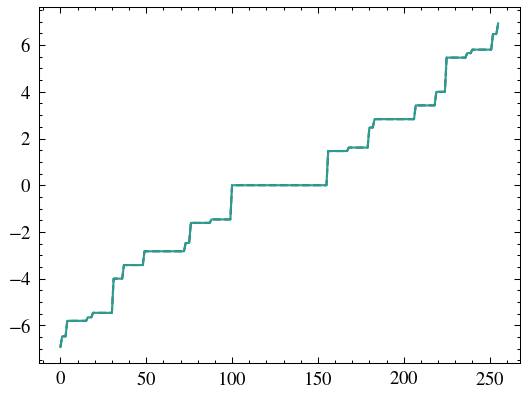

In [17]:
plt.plot(np.sort(all_energies), label = 'sym', ls = '--')
plt.plot(model_no_sym.eig_val, label = 'sym', ls = '-')